# Numerical Solution of Vibrational Problems Using a Discrete Variable Representation

Previously in the semester we introduced the variational principle as a method of numerically solving the Schrodinger equation.  This method depended on having a good trial wavefunction to optimize.  It isn't always easy to develop good trial wavefunctions for a potential that you haven't encountered before.  Beyond that, the method depended on being able to represent the potential energy as a continuous function.  The Discrete Variable Representation (DVR) method overcomes both of these problems.

In particular, today we will be working with the sinc DVR.  A sinc DVR chooses a basis that consists of a set of evenly spaced delta functions.  This results in a Hamiltonian matrix with a diagonal potential term, but a non-diagonal kinetic energy term.

Because the basis functions are just delta functions, it is very easy to add in additional basis functions, and hence increase the accuracy of the calculation.  It also makes the approach very general and easy to apply to any 1 dimensional problem.

Today we will explore the sinc DVR for the simple harmonic oscillator (SHO), the Morse Potential, and a double well.

## SHO
Execute the next several cells to load them into your kernel.

In [1]:
# import modules
import numpy as np
import pandas as pd # if import fails, uncomment next line and run again
#!pip install pandas
from sympy import *
import matplotlib.pyplot as plt
init_printing()

In [2]:
# define constants
hbar = 6.626e-34/(2*np.pi) * 1/ 1.6605e-27 * (1e10)**2 * 1/1e12 # hbar in units of amu ang^2/ps
c = 2.998e-2 # speed of light in cm/ps
conv=2*np.pi*c*hbar # conversion to and from simulation units to cm^-1

In [3]:
def return_KE(num,dx):
    """Returns the kinetic energy matrix for a num DVR grid 
    where grid points are separated by dx
    see http://www.pci.uni-heidelberg.de/tc/usr/mctdh/lit/NumericalMethods.pdf 
    page 29 for more details"""
    
    KE=np.zeros((num,num))
    for i in range(num):
        for j in range(i):
            KE[i,j]= hbar**2/dx**2 * (-1)**(i-j)/(i-j)**2
            KE[j,i]=KE[i,j]
        KE[i,i]=hbar**2*np.pi**2/(6*dx**2)
    return KE/conv# conversion from simulation units to cm^-1
def return_H(xmin,xmax,pes,num=21,pconv=1,mass=1):
    """Returns the H matrix for a given pes.  pes is a sympy function of the variable x
    num is the number of DVR points.  Default of 21.
    pconv is an optional conversion of the pes.  Default of 1.
    mass is the reduced mass.  Default of 1."""
    nppes=lambdify(x,pes)
    xvals,dx=np.linspace(xmin,xmax,num=num,retstep=True)
    xpes=[]
    for val in xvals:
        xpes.append(nppes(val))
    KE=return_KE(num,dx)
    H=np.copy(KE)/mass
    for i in range(num):
        H[i,i]=H[i,i]+xpes[i]*pconv
    H = H
    return H,xvals

To start out, let's find the solutions to the simple harmonic oscillator to make sure that our code is working correctly.  In the next cell, I am defining the potential energy as $V(x) = 0.5 k x^2 = 0.5 m\omega^2 x^2$ with a $\widetilde{\nu}$ of 100 cm$^{-1}$

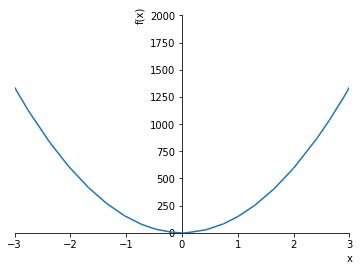

In [4]:
x=Symbol('x')
mass=1
sho = 0.5*mass*(2*np.pi*c*100)**2*x**2 /conv # conv does a conversion to wavenumbers
plot(sho,xlim=[-3,3],ylim=[0,2000])

When solving a problem numerically, one generally has to make compromises.  In other words, one typically has to choose between picking an approach that simplifies one part of the problem at the expense of another.  

The method that we are using today is a discrete variable representation (DVR), in particular a sinc-DVR.  This approach uses evenly spaced delta functions as basis functions to represent our wavefunctions.  The choice means that our potential energy is very simple to express, while our kinetic energy is more complicated.

Let's look at the kinetic energy matrix for a small DVR basis, consisting of 6 functions.  The function return_KE() defines this matrix and takes the number of DVR points and the spacing between them as an input.

In [5]:
num=6
xvals,dx=np.linspace(-2.5,2.5,num=num,retstep=True) # use same dx that we will below
KE=return_KE(num,dx)
pd.DataFrame(KE) # pandas provides an easy way to look at the data

,0,1,2,3,4,5
0,55.458700,-33.714846,8.428712,-3.746094,2.107178,-1.348594
1,-33.714846,55.458700,-33.714846,8.428712,-3.746094,2.107178
2,8.428712,-33.714846,55.458700,-33.714846,8.428712,-3.746094
3,-3.746094,8.428712,-33.714846,55.458700,-33.714846,8.428712
4,2.107178,-3.746094,8.428712,-33.714846,55.458700,-33.714846
5,-1.348594,2.107178,-3.746094,8.428712,-33.714846,55.458700


You can see that the diagonal entries are idential, while the off-diagonal values alternate between positive and negative and decrease with the distance between the delta functions - recall that the basis consists of evenly spaced delta functions so function 0 and 5 are as far apart as possible.  

The smaller the magnitude of the off-diagonal element, the less coupling there is between these basis functions.

Our choice of the sinc-DVR makes the potential energy simple.  We just evaluate the potential at each DVR point, and add that value to the diagonal element of the kinetic energy to form our Hamiltonian.  Let's look at the Hamiltonian for this system, placing our DVR points from -2.5 to 2.5 Ang.  The function return_H() defines the Hamiltonian and takes the xmin,xmax, a sympy expression of x for the potential, and several optional arguments, such as the number of DVR points

In [6]:
num=6
H,xvals = return_H(-2.5,2.5,sho,num=num)
pd.DataFrame(H)

,0,1,2,3,4,5
0,982.350062,-33.714846,8.428712,-3.746094,2.107178,-1.348594
1,-33.714846,389.139590,-33.714846,8.428712,-3.746094,2.107178
2,8.428712,-33.714846,92.534354,-33.714846,8.428712,-3.746094
3,-3.746094,8.428712,-33.714846,92.534354,-33.714846,8.428712
4,2.107178,-3.746094,8.428712,-33.714846,389.139590,-33.714846
5,-1.348594,2.107178,-3.746094,8.428712,-33.714846,982.350062


Now that we have looked at the form of the Hamiltonian, let's obtain the eigenvalues and eigenvectors.  We will start with the same number of DVR points.  This will not produce a very good result, so we will need to eventually increase the number of basis functions.

Ev             Ev - Ev-1
50.00730289303438
149.83669701019068 99.8293941171563
251.18280393698547 101.34610692679479
342.5560761991697 91.37327226218423


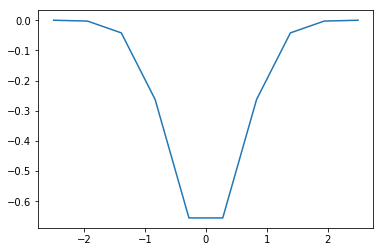

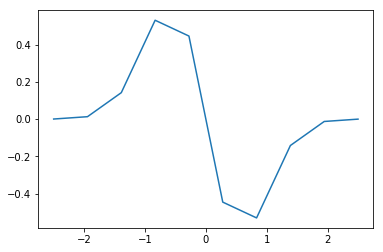

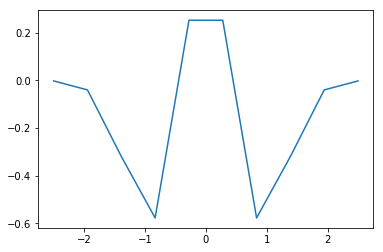

In [10]:
num=10
H,xvals = return_H(-2.5,2.5,sho,num=num)
w,v = np.linalg.eigh(H)

print("Ev             Ev - Ev-1")
for i in range(4):
    if (i == 0):
        print (w[i])
    else:
        print(w[i],w[i]-w[i-1])

for i in range(3):
    plt.plot(xvals,v[:,i])
    plt.show()



Re-run the above cell several times with an even number of DVR points that are increasing to see how the eigenvalues change as well as what the eigenfunctions look like.

We can actually use this to demonstrate how the variational method works.  By increasing the number of basis functions, we are moving towards a converged answer.

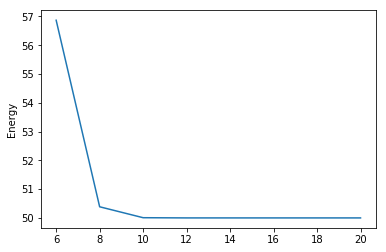

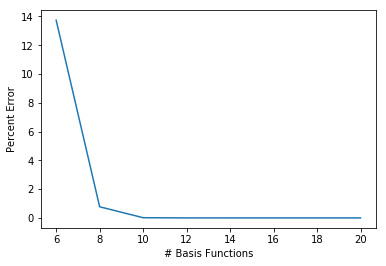

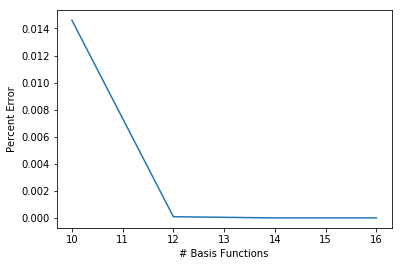

In [11]:
nums=[6,8,10,12,14,16,20]
eigs=[]
for num in nums:
    H,xvals = return_H(-2.5,2.5,sho,num=num)
    w,v = np.linalg.eigh(H)
    eigs.append(w[0])

plt.plot(nums,eigs)
plt.ylabel('Energy')
plt.show()
plt.plot(nums,(eigs-eigs[-1])/eigs[-1]*100)
plt.ylabel('Percent Error')
plt.xlabel('# Basis Functions')
plt.show()
plt.plot(nums[2:-1],(eigs[2:-1]-eigs[-1])/eigs[-1]*100)
plt.ylabel('Percent Error')
plt.xlabel('# Basis Functions')
plt.show()

# Morse Potential

Now we will explore the Morse potential.  This function is defined as $V(x)=D_e\left(\exp(-2\alpha x)-2\exp(-\alpha x)\right ) +D_e$.  Today we will use parameters of $D_e=35731.2$ cm$^{-1}$ and $\alpha=1.9519$ Ang., which corresponds to the HCl molecule.  Define a function called Morse as a sympy expression.  

Plot this function to get an idea of the shape and location for the potential with limits of x = -0.5 to 3, with a ylim=[0,40000].

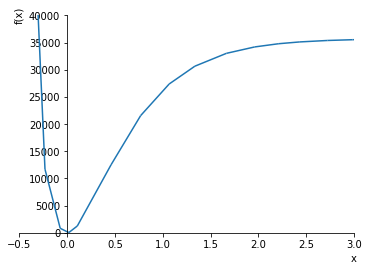

In [14]:
x=Symbol('x')
De = 35731.2
alpha = 1.9519
mass=1
morse = De*(exp(-2*alpha*x) - 2*exp(-alpha*x))+De   # conv does a conversion to wavenumbers
plot(morse,xlim=[-0.5,3],ylim=[0,40000])

Define another SHO function with equation $0.5 k x^2$ where k is the second deriviative of your Morse function evaluated at x=0.  Plot both this function and the Morse potential to determine the appropriate DVR range to solve for the first several energy levels.  Note that you will want a smaller x range than in the above plot.

272265.570363264


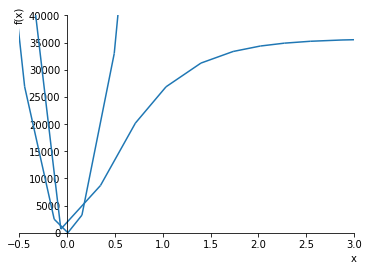

In [28]:
k = (diff(morse, x, x)).subs({x:0})
print(k)

SHO = 0.5*k*x**2

p1 = plot(morse,xlim=[-0.5,3],ylim=[0,40000],show=False)
p2 = plot(SHO,xlim=[-0.5,3],ylim=[0,40000],show=False)
p1.append(p2[0])
p1.show()


Now that you have the range identified, find the eigenvalues and eigenvectors of both the morse potential and the harmonic approximation.  Compare the ground state energy of each as well as the transition energy for v = 0 to v = 1.  Use a large number of DVR points, such as 100.  Call return_H using the optional argument of mass=35/36. to account for the reduced mass of HCl.

In [29]:
num=6
xvals,dx=np.linspace(-2.5,2.5,num=num,retstep=True) # use same dx that we will below
KE=return_KE(num,dx)
pd.DataFrame(KE) # pandas provides an easy way to look at the data

,0,1,2,3,4,5
0,55.458700,-33.714846,8.428712,-3.746094,2.107178,-1.348594
1,-33.714846,55.458700,-33.714846,8.428712,-3.746094,2.107178
2,8.428712,-33.714846,55.458700,-33.714846,8.428712,-3.746094
3,-3.746094,8.428712,-33.714846,55.458700,-33.714846,8.428712
4,2.107178,-3.746094,8.428712,-33.714846,55.458700,-33.714846
5,-1.348594,2.107178,-3.746094,8.428712,-33.714846,55.458700


Now compare the wavefunctions for the first 4 eigenfunctions.  Include a statement such as color='red' in your plot command so that you can tell the difference between the two functions.

<b>Note:</b> The phase of the wavefunction is random and it it may be necessary to plot the negative of the eigenfunction for either the SHO or Morse system to make an easy comparison.

In [12]:
#Ans Cell


# Double Well Potential

Now let's examine a double well potential. Define a potential energy function $V(x)=\alpha x^4 - \beta x^2 + \frac{\beta^2}{4\alpha}$ with $\alpha=533.33$ and $\beta=2400$.  Plot this function, with Ylim=[0,10000].

In [13]:
#Ans Cell


Use the plot to determine the DVR range and find the eigenvalues and eigenfunctions. 

Examine the first two energy levels and wavefunctions and discuss what you see.  Again, use a large number of DVR points, such as num=100.

In [14]:
# Ans Cell


Examine the second two energy levels.  What do you expect the wavefunctions to look like?

In [15]:
#Ans Cell
